In [12]:
#import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate,Conv1D, MaxPooling1D,Flatten
from tensorflow.keras.models import Model,Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time
from keras.preprocessing.image import ImageDataGenerator


In [2]:
#class inputs
base_path = r"C:\Users\lenovo\\DualChannelThesis\CWRU"

statistics_directories = [
    base_path + "\\stats\\bopolar7",
    base_path + "\\stats\\bopolar14",
    base_path + "\\stats\\bopolar21",
    base_path + "\\stats\\irpolar7",
    base_path + "\\stats\\irpolar14",
    base_path + "\\stats\\irpolar21",
    base_path + "\\stats\\orpolar7",
    base_path + "\\stats\\orpolar14",
    base_path + "\\stats\\orpolar21",
]

image_directories = [
    base_path + "\\spectogtam\\bopolar7",
    base_path + "\\spectogtam\\bopolar14",
    base_path + "\\spectogtam\\bopolar21",
    base_path + "\\spectogtam\\irpolar7",
    base_path + "\\spectogtam\\irpolar14",
    base_path + "\\spectogtam\\irpolar21",
    base_path + "\\spectogtam\\orpolar7",
    base_path + "\\spectogtam\\orpolar14",
    base_path + "\\spectogtam\\orpolar21",
]


In [3]:
#class labeling
def get_label(directory):
    if "bopolar" in directory:
        return 0  # bopolar
    elif "irpolar" in directory:
        return 1  # irpolar
    else:
        return 2  # orpolar


In [4]:
statistics_data = []
statistics_labels = []
for directory in statistics_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            if not df.empty:
                features = df.values.flatten()
                statistics_data.append(features)
                statistics_labels.append(get_label(directory))

In [5]:
polar_images = []
polar_labels = []
for directory in image_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.png'):
            file_path = os.path.join(directory, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            polar_images.append(img)
            polar_labels.append(get_label(directory))

In [6]:
polar_images = np.array(polar_images)
polar_labels = np.array(polar_labels)

statistics_data = np.array(statistics_data)
statistics_labels = np.array(statistics_labels)

In [7]:
#splitting
statistics_X_train, statistics_X_test, statistics_y_train, statistics_y_test = train_test_split(
    statistics_data, statistics_labels, test_size=0.2, random_state=42)

In [8]:
#scaling the numeric statistical input
scaler = StandardScaler()
statistics_X_train = scaler.fit_transform(statistics_X_train)
statistics_X_test = scaler.transform(statistics_X_test)

In [9]:
polar_X_train, polar_X_test, polar_y_train, polar_y_test = train_test_split(
    polar_images, polar_labels, test_size=0.2, random_state=42)

In [10]:
#Generating class weight
class_counts = Counter(statistics_labels)
total_samples = len(statistics_labels)
class_weights = {class_index: total_samples / (class_count * len(class_counts)) for class_index, class_count in class_counts.items()}


In [13]:
#generate data as a data augmentation step

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(polar_X_train)

In [14]:
#define inputs
statistics_input = Input(shape=(statistics_X_train.shape[1],1))
polar_input = Input(shape=(64, 64, 3))

In [15]:
#define statistic based 1D CNN model
def statistics_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape, padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 2, activation='relu', padding="same"))  # Changed kernel size to 2
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


In [16]:
polar_base_model = NASNetMobile(include_top=False, weights='imagenet', input_tensor=polar_input)
polar_output = GlobalAveragePooling2D()(polar_base_model(polar_input))

statistics_branch_model = statistics_model((statistics_X_train.shape[1], 1))
statistics_output = statistics_branch_model(statistics_input)

In [17]:
#concatanating the features from both channels

combined_input = concatenate([statistics_output, polar_output])
x = Dense(256, activation='relu')(combined_input)
x = Dropout(0.5)(x)
output = Dense((3), activation='softmax')(x)

In [18]:
model = Model(inputs=[statistics_input, polar_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
#model training
epochs_list = [20,30]
batch_sizes_list = [32,64]
results = []
best_accuracy = 0.0  # Initialize best_accuracy
best_time = 0.0
for epoch in epochs_list:
    for batch_size in batch_sizes_list:
        print(f"Training with {epoch} epochs and batch size {batch_size}")
        start_time = time.time()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit([statistics_X_train, polar_X_train],
                            polar_y_train,
                            epochs=epoch,
                            batch_size=batch_size,
                            validation_split=0.2,
                            class_weight=class_weights)
        end_time = time.time()
        elapsed_time = end_time - start_time
        # Evaluation
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)
        predictions = model.predict([statistics_X_test, polar_X_test])
        predicted_labels = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(statistics_y_test, predicted_labels)
        f1 = f1_score(statistics_y_test, predicted_labels, average='weighted')
        precision_vals = precision_score(statistics_y_test, predicted_labels, average=None)
        recall_vals = recall_score(statistics_y_test, predicted_labels, average=None)

        n_classes = 3  # Number of classes
        fpr = dict()
        tpr = dict()
        roc_auc_vals = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(statistics_y_test, predictions[:, i], pos_label=i)
            roc_auc_vals[i] = auc(fpr[i], tpr[i])

        results.append({
            'epochs': epoch,
            'batch_size': batch_size,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision_vals,
            'recall': recall_vals,
            'roc_auc': roc_auc_vals
        })
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_time = elapsed_time


Training with 20 epochs and batch size 32
Epoch 1/20
36/36 [==============================] - 105s 924ms/step - loss: 0.7258 - accuracy: 0.7425 - val_loss: 100.3266 - val_accuracy: 0.3286
Epoch 2/20
36/36 [==============================] - 36s 1s/step - loss: 0.1725 - accuracy: 0.9558 - val_loss: 72.4804 - val_accuracy: 0.3286
Epoch 3/20
36/36 [==============================] - 38s 1s/step - loss: 0.0925 - accuracy: 0.9823 - val_loss: 62.3272 - val_accuracy: 0.3286
Epoch 4/20
36/36 [==============================] - 40s 1s/step - loss: 0.0699 - accuracy: 0.9770 - val_loss: 16.5634 - val_accuracy: 0.3286
Epoch 5/20
36/36 [==============================] - 36s 993ms/step - loss: 0.0738 - accuracy: 0.9823 - val_loss: 48.2812 - val_accuracy: 0.3286
Epoch 6/20
36/36 [==============================] - 36s 989ms/step - loss: 0.0068 - accuracy: 0.9973 - val_loss: 49.9537 - val_accuracy: 0.3286
Epoch 7/20
36/36 [==============================] - 36s 1s/step - loss: 0.0173 - accuracy: 0.9965 - v

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 3s 216ms/step - loss: 80.0356 - accuracy: 0.2938
Training with 20 epochs and batch size 64
Epoch 1/20
18/18 [==============================] - 34s 2s/step - loss: 9.1894e-04 - accuracy: 1.0000 - val_loss: 74.4998 - val_accuracy: 0.3286
Epoch 2/20
18/18 [==============================] - 34s 2s/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 66.1312 - val_accuracy: 0.3286
Epoch 3/20
18/18 [==============================] - 34s 2s/step - loss: 6.5013e-04 - accuracy: 1.0000 - val_loss: 60.2743 - val_accuracy: 0.3286
Epoch 4/20
18/18 [==============================] - 34s 2s/step - loss: 5.1498e-04 - accuracy: 1.0000 - val_loss: 56.3517 - val_accuracy: 0.3286
Epoch 5/20
18/18 [==============================] - 32s 2s/step - loss: 2.7708e-04 - accuracy: 1.0000 - val_loss: 53.9184 - val_accuracy: 0.3286
Epoch 6/20
18/18 [==============================] - 36s 2s/step - loss: 5.7495e-04 - accuracy: 1.0000 - val_loss: 52.7310 - val_accuracy: 0.3286
Ep

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 82ms/step - loss: 32.1950 - accuracy: 0.2938
Training with 30 epochs and batch size 32
Epoch 1/30
36/36 [==============================] - 21s 599ms/step - loss: 5.7215e-05 - accuracy: 1.0000 - val_loss: 28.1843 - val_accuracy: 0.3286
Epoch 2/30
36/36 [==============================] - 24s 660ms/step - loss: 9.2241e-05 - accuracy: 1.0000 - val_loss: 25.9063 - val_accuracy: 0.3322
Epoch 3/30
36/36 [==============================] - 28s 783ms/step - loss: 6.6405e-04 - accuracy: 1.0000 - val_loss: 21.3818 - val_accuracy: 0.3322
Epoch 4/30
36/36 [==============================] - 23s 629ms/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 11.9831 - val_accuracy: 0.3640
Epoch 5/30
36/36 [==============================] - 23s 646ms/step - loss: 0.0067 - accuracy: 0.9965 - val_loss: 5.1264 - val_accuracy: 0.4417
Epoch 6/30
36/36 [==============================] - 21s 586ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.4736 - val_accuracy: 0.

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 78ms/step - loss: 759.4508 - accuracy: 0.2938
Training with 30 epochs and batch size 64
Epoch 1/30
18/18 [==============================] - 15s 820ms/step - loss: 1.1956e-04 - accuracy: 1.0000 - val_loss: 568.9674 - val_accuracy: 0.3286
Epoch 2/30
18/18 [==============================] - 15s 866ms/step - loss: 1.7013e-05 - accuracy: 1.0000 - val_loss: 512.9966 - val_accuracy: 0.3286
Epoch 3/30
18/18 [==============================] - 16s 873ms/step - loss: 1.7332e-05 - accuracy: 1.0000 - val_loss: 479.0125 - val_accuracy: 0.3286
Epoch 4/30
18/18 [==============================] - 16s 890ms/step - loss: 2.0152e-04 - accuracy: 1.0000 - val_loss: 465.4946 - val_accuracy: 0.3286
Epoch 5/30
18/18 [==============================] - 15s 819ms/step - loss: 3.1354e-05 - accuracy: 1.0000 - val_loss: 443.5953 - val_accuracy: 0.3286
Epoch 6/30
18/18 [==============================] - 16s 914ms/step - loss: 1.0720e-04 - accuracy: 1.0000 - val_loss: 415.93

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 78ms/step - loss: 112.2861 - accuracy: 0.3051


In [20]:
# print Validation, Accuracy, F1-Score
for result in results:
    print(f"Epochs: {result['epochs']}, Batch Size: {result['batch_size']}, Test Accuracy: {result['test_accuracy']}, F1-Score: {result['f1_score']}")
print(f"Time taken for best hyperparameters (with test accuracy {best_accuracy:.2f}): {best_time:.2f} seconds")


Epochs: 20, Batch Size: 32, Test Accuracy: 0.29378530383110046, F1-Score: 0.13342214985320605
Epochs: 20, Batch Size: 64, Test Accuracy: 0.29378530383110046, F1-Score: 0.13342214985320605
Epochs: 30, Batch Size: 32, Test Accuracy: 0.29378530383110046, F1-Score: 0.13342214985320605
Epochs: 30, Batch Size: 64, Test Accuracy: 0.3050847351551056, F1-Score: 0.15744920790956682
Time taken for best hyperparameters (with test accuracy 0.31): 474.71 seconds


In [21]:
#best results
best_result_test = max(results, key=lambda x: x['test_accuracy'])
print("\nBest Hyperparameters (Test Accuracy):")
print("Epochs:", best_result_test['epochs'])
print("Batch Size:", best_result_test['batch_size'])
print("Test Accuracy:", best_result_test['test_accuracy'])


Best Hyperparameters (Test Accuracy):
Epochs: 30
Batch Size: 64
Test Accuracy: 0.3050847351551056


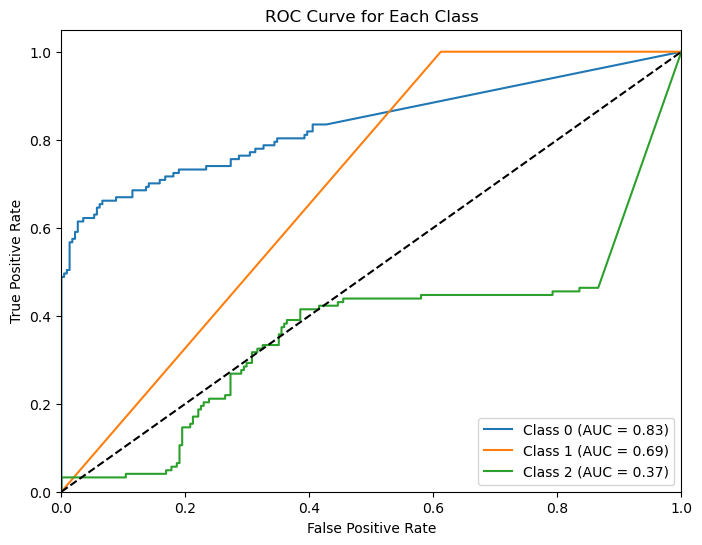

In [22]:
#plot roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(polar_y_test, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [23]:
precision = precision_score(polar_y_test, predicted_labels, average=None)
recall = recall_score(polar_y_test, predicted_labels, average=None)

print("\nPrecision for Each Class:", precision)
print("Recall for Each Class:", recall)



Precision for Each Class: [0.         0.303207   0.36363636]
Recall for Each Class: [0.         1.         0.03252033]


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


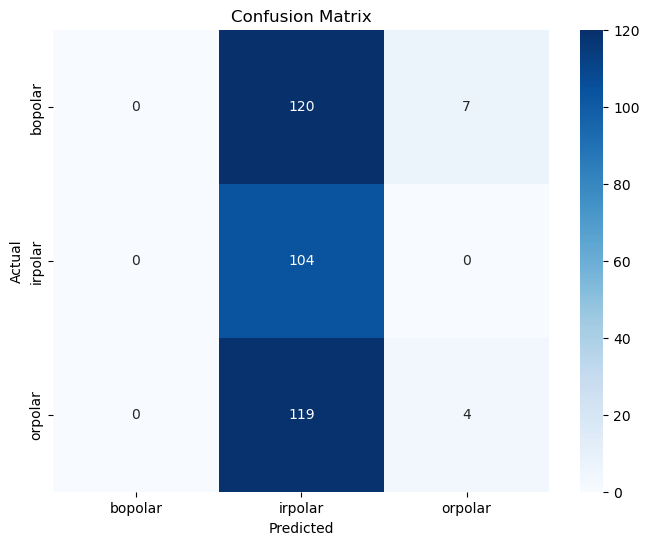

In [24]:
#plot conf_matrix
conf_matrix = confusion_matrix(polar_y_test, predicted_labels)
class_labels = ['bopolar', 'irpolar', 'orpolar']
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
